In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.model_selection import cross_val_score
import scipy.optimize as opt
import pylab as pl
import seaborn as sns
import itertools
%matplotlib inline

Importing the dataframe with restaurants data 
* 1184 samples
* Features normalized 
* Standard deviation 1

In [193]:
df_full = pd.read_csv('CSVs/Restaurants_Full_Grouped_sorted.csv')
df = df_full.copy()

Feature Set:<br>
'Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum',
       'Restaurant', 'Company', 'Liffey', 'Price Area' <br>
       
Target (class):<br>
'Ranking'

In [3]:
df.describe()

,Reviews,District,Company KNN,RankingN,Ranking,Rating,Rating_G,Hotel,Tourism,Cafe,Pub,Museum,Restaurant,University,Luas,Company,Liffey,Price Area
count,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000
mean,278.181588,3.310811,3.545380,0.005386,867.271959,4.142736,3.941723,2.536700,2.248556,2.676784,2.157995,2.469796,2.271770,1.987705,1.481199,2.574875,1.468839,4.156939
std,555.834839,2.502682,0.999940,0.033692,583.166971,0.568531,0.844143,0.998517,0.998023,0.998991,0.999495,0.998122,0.999203,0.999410,1.000347,0.997594,1.000020,0.798360
min,1.000000,1.000000,1.374480,0.000489,1.000000,1.000000,3.000000,0.107947,0.000000,0.192498,0.069379,0.036527,0.062654,0.000000,0.182656,0.000000,0.220071,1.000000
25%,12.000000,2.000000,2.398029,0.000739,352.750000,4.000000,3.000000,1.776215,1.509178,1.896109,1.338030,1.716746,1.470521,1.287794,0.707112,1.925656,0.571429,3.445086
50%,71.000000,2.000000,3.556946,0.001278,782.500000,4.000000,4.000000,2.708483,2.364379,2.824913,2.137545,2.629908,2.307133,1.967463,1.147231,2.731787,1.173413,4.262323
75%,300.250000,6.000000,4.309886,0.002835,1353.750000,4.500000,5.000000,3.395417,3.144121,3.686343,2.989094,3.396965,3.168622,2.790220,2.161236,3.253508,2.396161,4.988360
max,6164.000000,12.000000,5.410362,1.000000,2045.000000,5.000000,5.000000,4.023471,3.722639,4.080965,3.977750,4.054442,3.904190,4.721910,3.349916,5.101268,3.017075,4.988360


We got about 60% accuracy trying to classify our model between 3 subcategories of the Rating that the website from where we had collected the data had asigned to each restaurant. We have shown that this class isn't the most optimal because some samples (restaurants) hadn't been classified by the website coherently in some cases. This is decreasing the accuracy of our prediction model.<br> Two simple facts are clear: The lower in the ranking is the better; the number of reviews indicates customer's volume visiting the restaurant, which can be seen as higher income.<br> So instead using the Rating, let's see how our classifier's performance will be if we give to our samples 4 new binomial labels. Top_100, Top_250, Top_500, and Top_750. In my opinion this would be an interesting data to play with: if our new restaurant has the potential of being a Top_100 in the Ranking due to location atributes, it means success. If not, we run the Top_250 model to see if our new restaurante belong to that range. Same with Top_500 if the Top_250 support vector declares the new restaurant out of the boundaries of the Top 250 ranking. 

Firstly we create 4 new columns for Rankings in order to use them as binomial classification
 * Top 100
 * Top 250
 * Top 500
 * Top 750

In [222]:
df.loc[(df['Ranking'] <= 100), 'Top_100'] = 1
df.loc[(df['Ranking'] > 100), 'Top_100'] = 0
df.loc[(df['Ranking'] <= 250), 'Top_250'] = 1
df.loc[(df['Ranking'] > 250), 'Top_250'] = 0
df.loc[(df['Ranking'] <= 500), 'Top_500'] = 1
df.loc[(df['Ranking'] > 500), 'Top_500'] = 0
df.loc[(df['Ranking'] <= 750), 'Top_750'] = 1
df.loc[(df['Ranking'] > 750), 'Top_750'] = 0

In [223]:
#TEST

df.loc[(df['Ranking'] > 750), 'Top_R'] = 0
df.loc[(df['Ranking'] <= 750), 'Top_R'] = 1
df.loc[(df['Ranking'] <= 500), 'Top_R'] = 2
df.loc[(df['Ranking'] <= 250), 'Top_R'] = 3
df.loc[(df['Ranking'] <= 100), 'Top_R'] = 4

### KNN (K Nearest Neighbor) 

Here we define the feature set. We'll calculate the optimal k value using all features as first approach

In [10]:
X = df[['Hotel', 'Tourism', 'University', 'Cafe',
        'Pub', 'Luas', 'Museum','Restaurant', 'Company', 
        'Liffey', 'Price Area']].values 
y = df['Top_100'].values
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [11]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.85232068, 0.92405063, 0.91561181, 0.92827004, 0.92827004,
       0.92827004, 0.92405063, 0.92405063, 0.92405063, 0.92827004,
       0.92827004, 0.92827004, 0.92827004, 0.92827004, 0.92827004,
       0.92827004, 0.92827004, 0.92827004, 0.92827004])

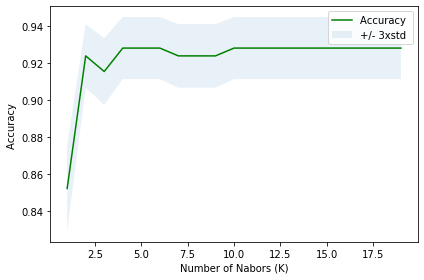

In [12]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [13]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.9282700421940928 with k= 4


#### Let's check with different combinations of feature set

Instead of trying a feature set that has been chosen during Feature selection, we will calculate all possible combinations of feature set. Which each one, we calculate the accuracy for k values from 1 to 20, and save the maximum k value on a new dataframe. After that, we can just sort this dataframe by accuracy and see which combination gives us the maximum accuracy.

In [14]:
features = ['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum','Restaurant', 'Company', 'Liffey', 'Price Area']
feat_combo = []
for L in range(1, len(features)+1):
    for subset in itertools.combinations(features, L):
        feat_combo.append(subset)
print ('There are {} different combinations of feature set'.format(len(feat_combo)))

There are 2047 different combinations of feature set


#### Regarding to the random_state parameter & Cross Validation when using train_test_split:

Having a fixed parameter random_state, will select the same random samples, due to this parameter is used to generate the randomness. <br>Therefore, in order to have Cross Validation we can split the dataset in subsets, train, test and validation, or we can iterate the classifier with different random_state parameter each time and use the median. In this case will be 0 to 10. In my opinion, with a dataset of about 1000 samples this is the best approach.

In [ ]:
space = '     ' # to print on same line while calculating
knn_combo = pd.DataFrame(columns=['combo', 'accuracy', 'k', 'f1_score', 'jaccard_score', 'random_state', 'nFeatures'])
j=0
for j in range(0,11):
    i=0
    for i in range (0, len(feat_combo)):
        X = df[list(feat_combo[i])].values 
        y = df['Top_100'].values
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=j)        
        Ks = 20
        mean_acc = np.zeros((Ks-1))
        std_acc = np.zeros((Ks-1))
        ConfustionMx = [];
        for n in range(1,Ks):
            neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
            yhat=neigh.predict(X_test)
            mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
            std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
        
        knn_combo.at[i, 'combo'] = feat_combo[i]
        knn_combo.at[i, 'accuracy'] = mean_acc.max()
        knn_combo.at[i, 'f1_score'] = f1_score(y_test, yhat, average='weighted')
        knn_combo.at[i, 'jaccard_score'] = jaccard_score(y_test, yhat, average='weighted')
        knn_combo.at[i, 'random_state'] = j
        knn_combo.at[i, 'nFeatures'] = len(list(feat_combo[i]))
        knn_combo.at[i, 'k'] = mean_acc.argmax()+1
        
        print( 'random_state:{},{}{}'.format(j, knn_combo.at[i, 'combo'], 10*space), end="\r", flush=True) 
    knn_total_top_100 = knn_total_top_100.append(knn_combo)

In [ ]:
knn_total_top_100.sort_values(by='accuracy', ascending=False).head(2)

And we do the same for Top_250, Top_500 & Top_750

### SVM (Support Vector Machine)

SVM works very well on smaller data sets, on non-linear data sets and high dimensional spaces. Not very sensitive to overfitting.<br>
When the data set has more noise (i.e. target classes are overlapping) SVM doesn’t perform well. We need to find classes that do not overlap. This is why using Ranking gives much better results than using Rating.


* We are running SVM classifier for all combinations of features.
* random_state from 0 to 40. This will serve as Cross Validation. Otherwise, fixing the seed (random_state) which generates the test set, wouldn't get optimal results. 
* Data has been splitted in 80/20 ratio, 80% for train set and 20% for test set.
* Regularization Parameter C has been fixed to 5 due to previous tests with this model. There's no increment on accuracy with values above 10. 
* Gamma parameter gave us beter results keeping the default (from version SVM 0.22) 'scale', which is 1/(n_features * X.var())
* Kernels ('linear', 'poly', 'rbf', 'sigmoid') also has been tested. Radial Basis Function was the most accurate followed by Polynomial. This is due to our model is non linear.
* F1-measure, which weights precision and recall equally, is the variant most often used when learning from imbalanced data. We cannot base our study just on accurancy for this model in particular.

In [ ]:
svm_total_top_100 = pd.DataFrame(columns=['combo', 'accuracy', 'f1_score', 'jaccard_score', 'random_state', 'nFeatures'])

In [ ]:
space = '     ' # to print on same line while calculating
svm_combo = pd.DataFrame(columns=['combo', 'accuracy', 'f1_score', 'jaccard_score', 'random_state', 'nFeatures'])
j=0
for j in range(0,41):
    i=0
    for i in range (0, len(feat_combo)):
        X = np.asarray(df[list(feat_combo[i])])  
        y = np.asarray(df['Top_100'])
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=j)
        clf = svm.SVC(kernel='rbf', C=5, gamma='scale')
        clf.fit(X_train, y_train)
        yhat = clf.predict(X_test)

        svm_combo.at[i, 'combo'] = feat_combo[i]
        svm_combo.at[i, 'accuracy'] = metrics.accuracy_score(y_test, yhat)
        svm_combo.at[i, 'f1_score'] = f1_score(y_test, yhat, average='weighted')
        svm_combo.at[i, 'jaccard_score'] = jaccard_score(y_test, yhat, average='weighted')
        svm_combo.at[i, 'random_state'] = j
        svm_combo.at[i, 'nFeatures'] = len(list(feat_combo[i]))
        
        print( 'random_state:{},{}{}'.format(j, svm_combo.at[i, 'combo'], 10*space), end="\r", flush=True) 
    svm_total_top_100 = svm_total_top_100.append(svm_combo)

In [ ]:
svm_total_top_100.sort_values(by='accuracy', ascending=False).head(2)

As we did with KNN, we generate the data for Top_250, Top_500 & Top_750 aswell

In [15]:
svm_total_top_100 = pd.read_csv('svm_total_top_100.csv')
svm_total_top_250 = pd.read_csv('svm_total_top_250.csv')
svm_total_top_500 = pd.read_csv('svm_total_top_500.csv')
svm_total_top_750 = pd.read_csv('svm_total_top_750.csv')

In [17]:
svm_total_top_100.sort_values(by='accuracy', ascending=False).head(2)

,combo,accuracy,f1_score,jaccard_score,random_state,nFeatures
69596,"('Tourism', 'University', 'Cafe', 'Pub', 'Luas...",0.962025,0.943405,0.925493,33,10
68573,"('Museum', 'Restaurant', 'Company', 'Liffey', ...",0.962025,0.943405,0.925493,33,5


In [237]:
svm_total_top_100.shape

(83927, 6)

In [238]:
lines

[0.94, 0.83, 0.67, 0.61]

In [243]:
svm_total_top_250 = pd.read_csv('charts/svm_total_top_250n.csv')
svm_total_top_500 = pd.read_csv('charts/svm_total_top_500n.csv')

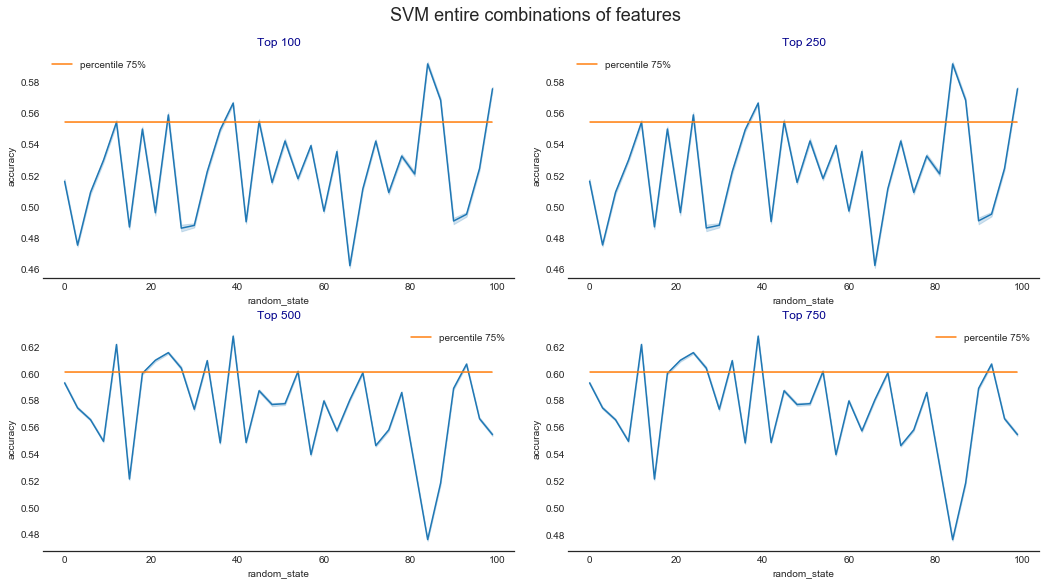

In [244]:
figures = [(0, 0), (0, 1), (1, 0), (1, 1)]
axis_x = 'random_state'
axis_y = 'accuracy'
titles_figs =['Top 100', 'Top 250', 'Top 500', 'Top 750']
data_dfs = [svm_total_top_250, svm_total_top_250, svm_total_top_500, svm_total_top_500]
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 8))
fig.tight_layout(pad=3.0)
fig.suptitle('SVM entire combinations of features', y=1.02, fontsize=18)
for data_df, titl, figs in zip(data_dfs, titles_figs, figures):
    sns.lineplot(x=axis_x, y=axis_y, data=data_df, ax=axs[figs])
    sns.lineplot(x=axis_x, y=data_df.accuracy.quantile(q=0.75), data=data_df, label='percentile 75%',
                 ax=axs[figs]).set_title(titl, color='darkblue')

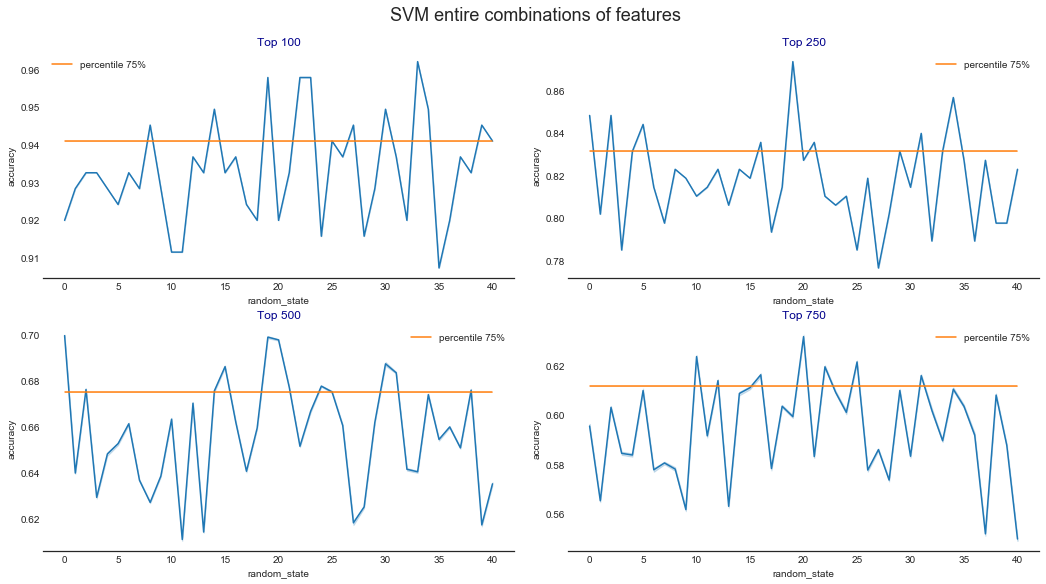

In [239]:
figures = [(0, 0), (0, 1), (1, 0), (1, 1)]
axis_x = 'random_state'
axis_y = 'accuracy'
titles_figs =['Top 100', 'Top 250', 'Top 500', 'Top 750']
data_dfs = [svm_total_top_100, svm_total_top_250, svm_total_top_500, svm_total_top_750]
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 8))
fig.tight_layout(pad=3.0)
fig.suptitle('SVM entire combinations of features', y=1.02, fontsize=18)
for data_df, titl, figs in zip(data_dfs, titles_figs, figures):
    sns.lineplot(x=axis_x, y=axis_y, data=data_df, ax=axs[figs])
    sns.lineplot(x=axis_x, y=data_df.accuracy.quantile(q=0.75), data=data_df, label='percentile 75%',
                 ax=axs[figs]).set_title(titl, color='darkblue')
#fig.savefig('charts/SVM_features_combinations.png', bbox_inches='tight', format='png', dpi=500)

Let's keep those combos that pass the threshold of percentile 75% accuracy

In [105]:
#top_100_acc = pd.DataFrame()
#top_250_acc = pd.DataFrame()
#top_500_acc = pd.DataFrame()
#top_750_acc = pd.DataFrame()
dfs = ['top_100_acc', 'top_250_acc', 'top_500_acc', 'top_750_acc']
data_dfs = [svm_total_top_100, svm_total_top_250, svm_total_top_500, svm_total_top_750]
for df, data in zip(dfs, data_dfs):
    df = data.loc[data['accuracy'] >= data.accuracy.quantile(q=0.75)].copy()
    #df.drop_duplicates('combo', keep='first', inplace=True)
    #df.sort_values(by=['accuracy'], ascending=False, inplace=True).head()
    #df.reset_index(drop=True, inplace=True)

In [96]:
top_100_acc = svm_total_top_100.loc[svm_total_top_100['accuracy'] >= svm_total_top_100.accuracy.quantile(q=0.75)].copy()

In [144]:
feature_set = ['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 
               'Luas', 'Museum','Restaurant', 'Company', 'Liffey', 'Price Area']
df_app = pd.DataFrame()
data_dfs = [svm_total_top_100, svm_total_top_250, svm_total_top_500, svm_total_top_750]
for ind, data in zip(range(0,4), data_dfs):
    df_temp = pd.DataFrame()
    df_temp = data.loc[data['accuracy'] >= data.accuracy.quantile(q=0.75)].copy()
    #df_temp =  data.copy()
    df_temp.drop_duplicates('combo', keep='first', inplace=True)
    df_temp.sort_values(by=['accuracy'], ascending=False, inplace=True)
    df_temp.reset_index(drop=True, inplace=True)
    for feat in feature_set:
        df_app.at[ind, feat] = df_temp.loc[df_temp['combo'].str.contains(feat), 'combo'].count()
    

In [145]:
df_app

,Hotel,Tourism,University,Cafe,Pub,Luas,Museum,Restaurant,Company,Liffey,Price Area
0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0
1,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0
2,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0
3,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0


In [122]:
df_temp.combo[5]

"('Tourism', 'Cafe', 'Luas', 'Museum', 'Liffey', 'Price Area')"

In [146]:
df_temp.loc[df_temp['combo'].str.contains('Pub')]

,combo,accuracy,f1_score,jaccard_score,random_state,nFeatures
0,"('Hotel', 'Tourism', 'University', 'Pub', 'Mus...",0.645570,0.643546,0.477236,0,6
1,"('Hotel', 'Tourism', 'University', 'Pub', 'Mus...",0.641350,0.638984,0.472488,0,7
2,"('Hotel', 'Tourism', 'University', 'Pub', 'Mus...",0.641350,0.635917,0.470579,0,6
3,"('Tourism', 'University', 'Pub', 'Museum')",0.641350,0.631882,0.467968,0,4
4,"('Hotel', 'Cafe', 'Pub', 'Museum', 'Restaurant...",0.641350,0.640685,0.473471,0,7
...,...,...,...,...,...,...
2020,"('Cafe', 'Pub', 'Luas', 'Restaurant')",0.556962,0.552289,0.386137,0,4
2021,"('Hotel', 'University', 'Cafe', 'Pub', 'Luas',...",0.556962,0.558765,0.388030,0,8
2022,"('Hotel', 'Cafe', 'Pub', 'Luas')",0.556962,0.555509,0.387634,0,4
2025,"('Tourism', 'Cafe', 'Pub', 'Luas', 'Restaurant...",0.552743,0.552743,0.384201,0,6


In [139]:
df_temp['combo']

0                                              ('Hotel',)
1       ('Tourism', 'Cafe', 'Pub', 'Museum', 'Liffey',...
2       ('Tourism', 'Cafe', 'Luas', 'Restaurant', 'Lif...
3       ('Tourism', 'Cafe', 'Luas', 'Restaurant', 'Com...
4       ('Tourism', 'Cafe', 'Luas', 'Restaurant', 'Com...
                              ...                        
2042    ('Hotel', 'University', 'Pub', 'Restaurant', '...
2043    ('Hotel', 'University', 'Pub', 'Restaurant', '...
2044    ('Hotel', 'University', 'Pub', 'Restaurant', '...
2045    ('Hotel', 'University', 'Pub', 'Museum', 'Pric...
2046    ('Hotel', 'Tourism', 'University', 'Cafe', 'Pu...
Name: combo, Length: 2047, dtype: object

In [148]:
svm_total_top_100.shape

(83927, 6)

In [106]:
top_250_acc

""


In [162]:
svm_total_top_500['combo'].str.contains('Pub').sum()

41984

In [185]:
df_temp = svm_total_top_250.copy()

In [186]:
df_temp.shape

(83927, 6)

In [187]:
df_temp2 = df_temp.loc[df_temp['accuracy'] >= df_temp.accuracy.quantile(q=0.75)].copy()

In [188]:
df_temp2.shape

(22517, 6)

In [189]:
df_temp2.drop_duplicates('combo', keep='first', inplace=True)

In [190]:
df_temp2.shape

(2047, 6)

In [191]:
df_temp2['combo'].str.contains('Hotel').sum()

1024

=====================test=============


In [ ]:
space = '     ' # to print on same line while calculating
svm_combo = pd.DataFrame(columns=['combo', 'accuracy', 'f1_score', 'jaccard_score', 'random_state', 'nFeatures'])
j=0
for j in range(0,41):
    i=0
    for i in range (0, len(feat_combo)):
        X = np.asarray(df[list(feat_combo[i])])  
        y = np.asarray(df['Top_100'])
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=j)
        clf = svm.SVC(kernel='rbf', C=5, gamma='scale')
        clf.fit(X_train, y_train)
        yhat = clf.predict(X_test)

        svm_combo.at[i, 'combo'] = feat_combo[i]
        svm_combo.at[i, 'accuracy'] = metrics.accuracy_score(y_test, yhat)
        svm_combo.at[i, 'f1_score'] = f1_score(y_test, yhat, average='weighted')
        svm_combo.at[i, 'jaccard_score'] = jaccard_score(y_test, yhat, average='weighted')
        svm_combo.at[i, 'random_state'] = j
        svm_combo.at[i, 'nFeatures'] = len(list(feat_combo[i]))
        
        print( 'random_state:{},{}{}'.format(j, svm_combo.at[i, 'combo'], 10*space), end="\r", flush=True) 
    svm_total_top_100 = svm_total_top_100.append(svm_combo)

In [194]:
df.shape

(1184, 24)

In [228]:
X = np.asarray(df[['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 
               'Luas', 'Museum','Restaurant', 'Price Area']])
y = np.asarray(df['Top_R'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = svm.SVC(kernel='rbf', C=5, gamma='scale')
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)

In [229]:
metrics.accuracy_score(y_test, yhat)

0.5654008438818565

In [231]:
print(X_train.shape)
print(y_train.shape)

(947, 9)
(947,)


In [233]:
y

array([4., 4., 4., ..., 0., 0., 0.])

In [218]:
df.describe()

,Reviews,District,Company KNN,RankingN,Ranking,Rating,Rating_G,Hotel,Tourism,Cafe,...,Restaurant,University,Luas,Company,Liffey,Price Area,Top_100,Top_250,Top_500,Top_750
count,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,...,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000
mean,278.181588,3.310811,3.545380,0.005386,867.271959,4.142736,3.941723,2.536700,2.248556,2.676784,...,2.271770,1.987705,1.481199,2.574875,1.468839,4.156939,1.070101,1.181588,1.352196,1.483108
std,555.834839,2.502682,0.999940,0.033692,583.166971,0.568531,0.844143,0.998517,0.998023,0.998991,...,0.999203,0.999410,1.000347,0.997594,1.000020,0.798360,0.255426,0.385667,0.477856,0.499926
min,1.000000,1.000000,1.374480,0.000489,1.000000,1.000000,3.000000,0.107947,0.000000,0.192498,...,0.062654,0.000000,0.182656,0.000000,0.220071,1.000000,1.000000,1.000000,1.000000,1.000000
25%,12.000000,2.000000,2.398029,0.000739,352.750000,4.000000,3.000000,1.776215,1.509178,1.896109,...,1.470521,1.287794,0.707112,1.925656,0.571429,3.445086,1.000000,1.000000,1.000000,1.000000
50%,71.000000,2.000000,3.556946,0.001278,782.500000,4.000000,4.000000,2.708483,2.364379,2.824913,...,2.307133,1.967463,1.147231,2.731787,1.173413,4.262323,1.000000,1.000000,1.000000,1.000000
75%,300.250000,6.000000,4.309886,0.002835,1353.750000,4.500000,5.000000,3.395417,3.144121,3.686343,...,3.168622,2.790220,2.161236,3.253508,2.396161,4.988360,1.000000,1.000000,2.000000,2.000000
max,6164.000000,12.000000,5.410362,1.000000,2045.000000,5.000000,5.000000,4.023471,3.722639,4.080965,...,3.904190,4.721910,3.349916,5.101268,3.017075,4.988360,2.000000,2.000000,2.000000,2.000000


In [214]:
df[['Hotel', 'Pub']]

,Hotel,Pub
0,3.581871,2.629808
1,2.865497,2.639719
2,3.081390,2.352291
3,0.569174,0.327074
4,2.728110,2.312645
...,...,...
1179,2.041176,1.916192
1180,3.591684,2.652935
1181,1.481815,1.361157
1182,2.679043,2.107811


In [210]:
df['Top_100']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1179    0.0
1180    0.0
1181    0.0
1182    0.0
1183    0.0
Name: Top_100, Length: 1184, dtype: float64

Let's check with different combinations of feature set